### Account Relation Data Preprocessing

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

def transform_df_with_date(df, columnName, newColumnName):
  df[columnName] = df[columnName].apply(normalize_date)
  df.rename(columns={columnName: newColumnName}, inplace = True)

def normalize_date(accountDate):
  dateObj = datetime.strptime(str(accountDate), '%y%m%d')
  return relativedelta(datetime.now(), dateObj).years

account_data = pd.read_csv("./files/account.csv", sep=";", index_col=0)
transform_df_with_date(account_data, "date", "years_since_acc_open")
account_data.to_csv("./preprocessed/account.csv")

### Client Relation Data Preprocessing

In [2]:
import re

client_data = pd.read_csv("./files/client.csv", sep=";", index_col=0)

clientGenders = []
clientAgeGroup = []

def normalize_birthNumber(clientBirthNumber):
  dateSearch = re.search('(\d{2})(\d{2})(\d{2})', str(clientBirthNumber))
  years = int(dateSearch.group(1))
  months = int(dateSearch.group(2))
  days = int(dateSearch.group(3))
  
  gender = "M"
  if months > 12:
    gender = "F"
    months = months - 50

  dateObj = datetime.strptime(f"19{years}-{months}-{days}", '%Y-%m-%d')

  age = relativedelta(datetime.now(), dateObj).years

  if (age >= 80):
    age_group = "forth-age"
  elif (age >= 65):
    age_group = "third-age"
  elif (age >= 40):
    age_group = "half-age"
  elif (age >= 26):
    age_group = "adolthood"
  elif (age >= 20):
    age_group = "post-teenager"
  elif(age >= 15):
    age_group = "teenager"

  clientGenders.append(gender)
  clientAgeGroup.append(age_group)


client_data.birth_number = client_data.birth_number.apply(normalize_birthNumber)
client_data['gender'] = clientGenders
client_data['age_group'] = clientAgeGroup

client_data.drop(columns = ['birth_number'], inplace = True)
client_data.to_csv("./preprocessed/client.csv")

### Card Relation Data Preprocessing

In [3]:
card_test_data = pd.read_csv("./files/card_test.csv", sep=";", index_col=0)
card_train_data = pd.read_csv("./files/card_train.csv", sep=";", index_col=0)

transform_df_with_date(card_test_data, "issued", "years_since_issued")
transform_df_with_date(card_train_data, "issued", "years_since_issued")

card_test_data.to_csv("./preprocessed/card_test.csv")
card_train_data.to_csv("./preprocessed/card_train.csv")   

### Loan Relation Data Preprocessing

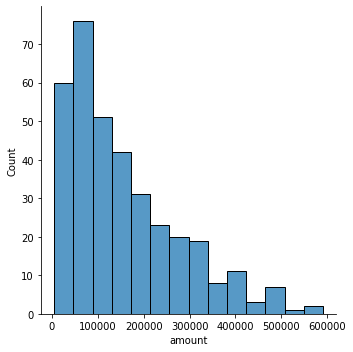

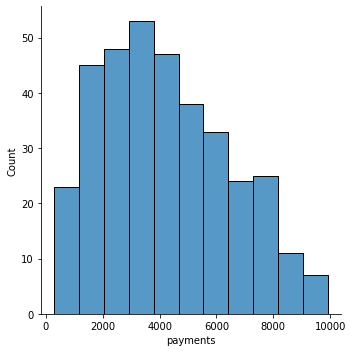

In [4]:
import seaborn as sb

def plot_distribution(df, column_name):
    sb.displot(df, x=column_name)

# def normalize_duration(duration):
#     duration = int(duration)

#     if duration >= 60:
#         durationLabel = "very_long"
#     elif duration >= 48:
#         durationLabel = "long"
#     elif duration >= 36:
#         durationLabel = "medium"
#     elif duration >= 24:
#         durationLabel = "short"
#     elif duration < 24:
#         durationLabel = "very_short"

#     return durationLabel

loan_test_data = pd.read_csv("./files/loan_test.csv", sep=";")
loan_train_data = pd.read_csv("./files/loan_train.csv", sep=";")

transform_df_with_date(loan_test_data, "date", "years_since_loan")
transform_df_with_date(loan_train_data, "date", "years_since_loan")
# loan_test_data.duration = loan_test_data.duration.apply(normalize_duration)
# loan_train_data.duration = loan_train_data.duration.apply(normalize_duration)

plot_distribution(loan_test_data, "amount")
plot_distribution(loan_test_data, "payments")

loan_test_data.to_csv("./preprocessed/loan_test_data.csv")   
loan_train_data.to_csv("./preprocessed/loan_train_data.csv")   

# TO DO
# Categorizar "amount" e "payments"

### Transational Relation Data Preprocessing

/Users/davidferreira/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


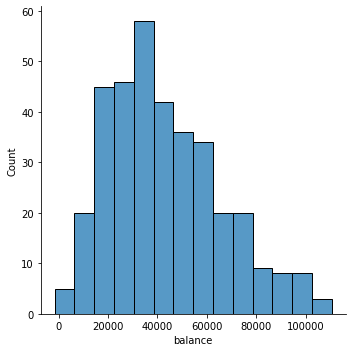

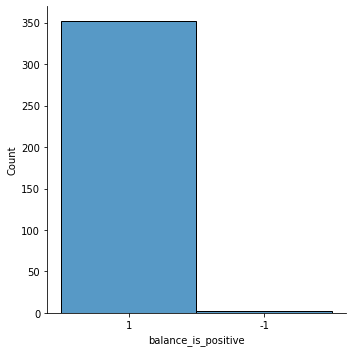

In [1]:
def preprocess_trans_data(df):
  df = df.sort_values(by=['date'], ascending=False)
  df = df.groupby(['account_id']).first()

  df.drop(columns = [
    'type',
    'operation',
    'amount',
    'k_symbol',
    'bank',
    'account',
    'date'
  ], inplace = True)
  
  return df

def checkIfBalanceIsPositive(row):
  if row['balance'] >= 0:
    return '1'
  else:
    return '-1'

trans_test_data = pd.read_csv("./files/trans_test.csv", sep=";", index_col=0)
trans_train_data = pd.read_csv("./files/trans_train.csv", sep=";", index_col=0)

trans_test_data = preprocess_trans_data(trans_test_data)
trans_train_data = preprocess_trans_data(trans_train_data)

trans_test_data['balance_is_positive'] = trans_test_data.apply(lambda row: checkIfBalanceIsPositive(row), axis=1)
trans_train_data['balance_is_positive'] = trans_train_data.apply(lambda row: checkIfBalanceIsPositive(row), axis=1)

plot_distribution(trans_test_data, "balance")
plot_distribution(trans_test_data, "balance_is_positive")

trans_test_data.to_csv("./preprocessed/trans_test_data.csv")  
trans_train_data.to_csv("./preprocessed/trans_train_data.csv") 

### District Relation Data Preprocessing
- Compute the average variation of North Moravia region regarding the unemployment rate in 95' and 96' and use it to substitute the "?" in "unemployment rate '95" column.
- Compute the average variation of North Moravia region regarding the number of commited crimes in 95' and 96' and use it to substitute the "?" in "no. of commited crimes '95" column.
- Sum and computed average of "unemploymant rate '95" e "unemploymant rate '96" columns and create new unemployment_rate column.
- Sum and computed average of "no. of commited crimes '95" e "no. of commited crimes '96" columns and create new no. of commited crimes column.
- Sum "no. of municipalities with inhabitants 500-1999" with "no. of municipalities with inhabitants 2000-9999" and create "no. of municipalities with inhabitants > 2000" column.
- Remove name column.

In [6]:
import numpy as np

district_data = pd.read_csv("./files/district.csv", index_col=None)
validDistrictData = district_data.loc[lambda df: (df["unemploymant rate '95 "] != "?") & (df["no. of commited crimes '95 "] != "?")] # The region where the "?" is located.

def avgVariationNMoravia(first_col, second_col):
  validDistrictData[first_col] = pd.to_numeric(validDistrictData[first_col])
  validDistrictData[second_col] = pd.to_numeric(validDistrictData[second_col])
  variationAll = np.subtract(validDistrictData[second_col], validDistrictData[first_col])

  return np.array([-y / x for x, y in zip(validDistrictData[second_col], variationAll)]).mean()

avgUnemploymentVariation = avgVariationNMoravia("unemploymant rate '95 ", "unemploymant rate '96 ")
avgCommitedCrimesVariation = avgVariationNMoravia("no. of commited crimes '95 ", "no. of commited crimes '96 ")

# Calculate "?" value in columns "unemploymant rate '95" and "no. of commited crimes '95"
knownUnemployment96 = district_data.loc[lambda df: df["unemploymant rate '95 "] == "?"]["unemploymant rate '96 "].item()
newUnemployment95 = (knownUnemployment96 + (knownUnemployment96 * avgUnemploymentVariation))
knownCommitedCrime96 = district_data.loc[lambda df: df["no. of commited crimes '95 "] == "?"]["no. of commited crimes '96 "].item()
newCommitedCrime95 = int(knownCommitedCrime96 + (knownCommitedCrime96 * avgCommitedCrimesVariation))

def computeTwoColumnsMean(district_data, first_col, second_col, final_col, newValue):
  district_data[first_col].replace({"?": newValue}, inplace=True)
  district_data[first_col] = pd.to_numeric(district_data[first_col])
  district_data[second_col] = pd.to_numeric(district_data[second_col])
  district_data[final_col] = np.add(district_data[first_col], district_data[second_col]).apply(lambda x: x / 2)
  
  return district_data

district_data = computeTwoColumnsMean(district_data, "unemploymant rate '95 ", "unemploymant rate '96 ", "unemployment_rate", newUnemployment95)
district_data = computeTwoColumnsMean(district_data, "no. of commited crimes '95 ", "no. of commited crimes '96 ", "no. of commited crimes", newCommitedCrime95)

district_data["no. of municipalities with inhabitants 500-1999"] = pd.to_numeric(district_data["no. of municipalities with inhabitants 500-1999"])
district_data["no. of municipalities with inhabitants 2000-9999 "] = pd.to_numeric(district_data["no. of municipalities with inhabitants 2000-9999 "])
district_data["no. of municipalities with inhabitants > 2000"] = np.add(district_data["no. of municipalities with inhabitants 500-1999"], district_data["no. of municipalities with inhabitants 2000-9999 "])

district_data.drop(columns = [
    "unemploymant rate '95 ",
    "unemploymant rate '96 ",
    "no. of municipalities with inhabitants 2000-9999 ",
    "no. of municipalities with inhabitants >10000 ",
    "no. of commited crimes '95 ",
    "no. of commited crimes '96 ",
    "name"
], inplace = True)

district_data.to_csv("./preprocessed/district.csv")

/tmp/ipykernel_318000/1142561627.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validDistrictData[first_col] = pd.to_numeric(validDistrictData[first_col])
/tmp/ipykernel_318000/1142561627.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validDistrictData[second_col] = pd.to_numeric(validDistrictData[second_col])


# Merging datasets
Merge all datasets and then compute train and test datasets. Funny fact: the loan_train is smaller than the loan_test.

### **TO DO: REFACTOR**

In [7]:
# Train Data
merged_data_train = pd.merge(loan_train_data, trans_train_data, on="account_id")
merged_data_train = pd.merge(merged_data_train, account_data, on="account_id")

#district_data = pd.read_csv("./files/district.csv", index_col=None)
district_data.rename(columns={"code": "district_id"}, inplace=True)
merged_data_train = pd.merge(merged_data_train, district_data, how="left", on="district_id")

disp_data = pd.read_csv("./files/disp.csv", sep=";")
merged_data_train = pd.merge(merged_data_train, disp_data, on="account_id")

# Remove rows with DISPONENT clients (because only owners can ask for a loan)
merged_data_train = merged_data_train.loc[lambda df: df['type'] != 'DISPONENT']

merged_data_train = pd.merge(merged_data_train, client_data, on="client_id")
# merged_data_train = pd.merge(merged_data_train, card_train_data, how="left", on="disp_id")

# Considerations:
# The merge with card data doesn't provide much data here. What should we do? Create UNKNOWN State?

merged_data_train.drop(columns = ['account_id', 'district_id_x', 'district_id_y', 'disp_id', 'client_id'], inplace = True)

# Test Data
merged_data_test = pd.merge(loan_test_data, trans_test_data, on="account_id")
merged_data_test = pd.merge(merged_data_test, account_data, on="account_id")

#district_data = pd.read_csv("./files/district.csv", index_col=None)
district_data.rename(columns={"code": "district_id"}, inplace=True)
merged_data_test = pd.merge(merged_data_test, district_data, how="left", on="district_id")

disp_data = pd.read_csv("./files/disp.csv", sep=";")
merged_data_test = pd.merge(merged_data_test, disp_data, on="account_id")

# Remove rows with DISPONENT clients (because only owners can ask for a loan)
merged_data_test = merged_data_test.loc[lambda df: df['type'] != 'DISPONENT']

merged_data_test = pd.merge(merged_data_test, client_data, on="client_id")
# merged_data_test = pd.merge(merged_data_test, card_test_data, how="left", on="disp_id")

# Considerations:
# The merge with card data doesn't provide much data here. What should we do? Create UNKNOWN State?
merged_data_test.drop(columns = ['account_id', 'district_id_x', 'district_id_y', 'disp_id', 'client_id'], inplace = True)

# Handling outliers
To remove the outlier, we use Z Score, which indicates how many standard deviation away a data point is.

In [8]:
from scipy import stats

def remove_outliers(df):
    z = np.abs(stats.zscore(df.select_dtypes(exclude=['object'])))

    df = df[(z < 3.2).all(axis=1)] # TODO: test with z < 3

    return df

number_of_rows = merged_data_train.shape[0]

merged_data_train = remove_outliers(merged_data_train)

print(f"Removed {number_of_rows - merged_data_train.shape[0]} outliers")

Removed 11 outliers


# Export preprocessed data

In [9]:
merged_data_train.to_csv("./preprocessed/mergedTrainData.csv", index=None)
merged_data_test.to_csv("./preprocessed/mergedTestData.csv", index=None)